LeNet是最早发布的卷积神经网络之一 </BR>
先使用卷积层来学习图片空间信息</BR>
然后使用全连接层来转换到类别空间

# 卷积神经网络 LeNet
LeNet (LeNet-5)由两个部分组成:卷积编码器和全连接层密集块

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [1]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16*5*5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

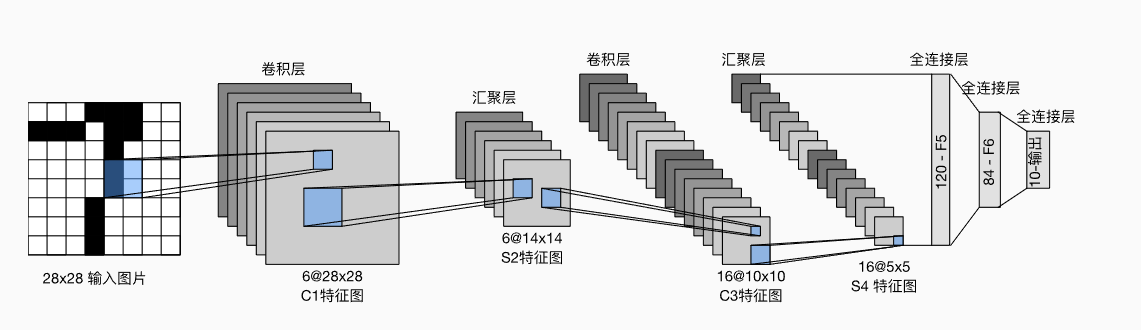
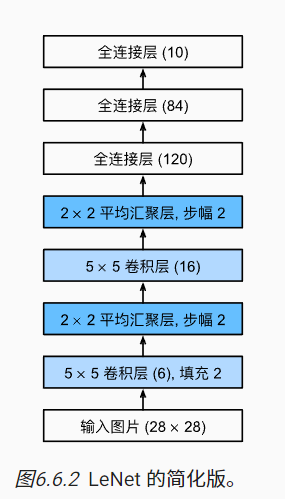

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


# 模型训练

LeNet在Fashion-MNIST数据集上的表现

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对evaluate_accuracy函数进行轻微的修改。由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中

In [3]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用GPU，我们还需要一点小改动。与train_epoch_ch3不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上

In [4]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估LeNet-5模型

loss 0.455, train acc 0.828, test acc 0.816
39941.2 examples/sec on cuda:0


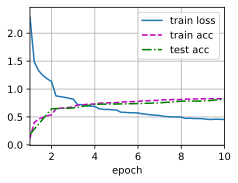

In [8]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1.将平均汇聚层替换为最大汇聚层，会发生什么？

loss 0.427, train acc 0.841, test acc 0.814
50525.0 examples/sec on cuda:0


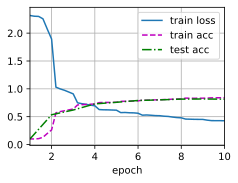

In [6]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16*5*5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
</br>
调整卷积窗口大小。
</br>
调整输出通道的数量。
</br>
调整激活函数（如ReLU）。
</br>
调整卷积层的数量。
</br>
调整全连接层的数量。
</br>
调整学习率和其他训练细节（例如，初始化和轮数）。

loss 0.320, train acc 0.880, test acc 0.868
61969.5 examples/sec on cuda:0


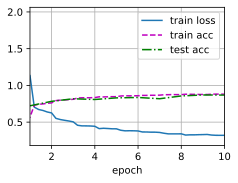

In [8]:
new_net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(6, 16, kernel_size=5),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Flatten(),
                        nn.Linear(16*5*5, 120),
                        nn.Sigmoid(),
                        nn.Linear(120, 84),
                        nn.Sigmoid(),
                        nn.Linear(84, 10))
lr, num_epochs = 0.9, 10
train_ch6(new_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.246, train acc 0.908, test acc 0.873
51268.5 examples/sec on cuda:0


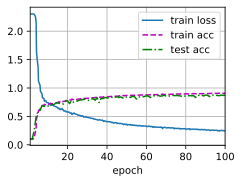

In [9]:
new_net = nn.Sequential(nn.Conv2d(1, 8, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(8, 32, kernel_size=3,padding=1),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 64, kernel_size=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Flatten(),
                        nn.Linear(64*3*3, 288),
                        nn.Sigmoid(),
                        nn.Linear(288, 144),
                        nn.Sigmoid(),
                        nn.Linear(144, 72),
                        nn.Sigmoid(),
                        nn.Linear(72, 10))
lr, num_epochs = 0.09, 20
train_ch6(new_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 高宽减半。通道数加倍

在MNIST数据集上尝试以上改进的网络

loss 0.309, train acc 0.885, test acc 0.843
51415.2 examples/sec on cuda:0


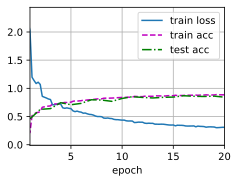

In [11]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=d2l.get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True,
                            num_workers=d2l.get_dataloader_workers())

new_net = nn.Sequential(nn.Conv2d(1, 8, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(8, 32, kernel_size=3,padding=1),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 64, kernel_size=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Flatten(),
                        nn.Linear(64*3*3, 288),
                        nn.Sigmoid(),
                        nn.Linear(288, 144),
                        nn.Sigmoid(),
                        nn.Linear(144, 72),
                        nn.Sigmoid(),
                        nn.Linear(72, 10))
lr, num_epochs = 0.5, 20
train_ch6(new_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.534, train acc 0.804, test acc 0.793
50251.6 examples/sec on cuda:0


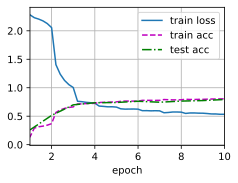

In [12]:
new_net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(6, 16, kernel_size=5),
                        nn.ReLU(),
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        nn.Flatten(),
                        nn.Linear(16*5*5, 120),
                        nn.ReLU(),
                        nn.Linear(120, 84),
                        nn.ReLU(),
                        nn.Linear(84, 10))
lr, num_epochs = 0.01, 10
train_ch6(new_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
#如果学习率还是0.9 Linear后面的Sigmod改成ReLU会没有下降 学习率太大了对于ReLU,对于ReLU来说。把学习率调小就会收敛